In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
#Select columns from deed, ols, tax that'll be used as features
deed_cols = ['COMPOSITE_PROPERTY_LINKAGE_KEY', 'COMPOSITE_TRANSACTION_ID','PROPERTY_INDICATOR_CODE',
                        'DEED_CATEGORY_TYPE', 'SALE_DATE', 'SALE_AMOUNT']
ols_cols = ['COMPOSITE_PROPERTY_LINKAGE_KEY','PURCHASE_AMOUNT','PURCHASE_COMBINED_LTV','ESTIMATED_EQUITY']
tax_cols = ['COMPOSITE_PROPERTY_LINKAGE_KEY', 'TOTAL_VALUE_CALCULATED', 'BEDROOMS', 'TOTAL_BATHROOMS_CALCULATED' ]


In [3]:
#load dataframes with selected columns
#Remove null dates in deed's sale dates, composite linkage keys, and property indicators. 
#Sort deed by composite linkage keys and sale dates
#Convert date column to datetime
#Add a dummy column for censored properties. Censor = 0 -> property hasn't undergone a title change yet
deed = pd.read_csv('deed_12_johns.csv',usecols=deed_cols, low_memory=False)
deed = deed.loc[deed['SALE_DATE'] != '0000-00-00']
deed.sort_values(by = ['COMPOSITE_PROPERTY_LINKAGE_KEY', 'SALE_DATE'], inplace = True)
deed.dropna(subset=['COMPOSITE_PROPERTY_LINKAGE_KEY', 'PROPERTY_INDICATOR_CODE'], inplace=True)
deed["censor"] = 1
deed = deed[pd.to_datetime(deed['SALE_DATE'], errors='coerce').notna()]
deed['SALE_DATE'] = pd.to_datetime(deed['SALE_DATE'])

ols = pd.read_csv("ols_12_johns.csv",usecols=ols_cols, low_memory = False)
ols.dropna(subset=['COMPOSITE_PROPERTY_LINKAGE_KEY'], inplace=True)


tax = pd.read_csv("tax_12_johns.csv", usecols=tax_cols, low_memory = False)


In [4]:
def get_targets(df):
    """a function that create censor (title change) and label(time that a property took to go through title changes)
    df: a deed df
    
    return two dictionaries, one that maps unique transaction ids to the time until the next title change or time until
    present if a title change hasn't occurred. The other dictionary contains the transaction ids mapping to an indicator
    of a title change or not ie the censor column.
    """
    
    # a dictionary of {property key: an array of timestamps of Sale Date
    deed_dates = df
    ids = {}
    dates = {}
    for idx, row in deed_dates.iterrows():
        key = row.COMPOSITE_PROPERTY_LINKAGE_KEY
        if key not in dates.keys():
            ids[key] = [row.COMPOSITE_TRANSACTION_ID]
            dates[key] = [row.SALE_DATE]
        else:
            ids[key].append( row.COMPOSITE_TRANSACTION_ID)
            dates[key].append(row.SALE_DATE )
    # a dictionary of {proporty key: an array of difference in Sale Date}
    diff_dict = {}
    c_ids = []
    for key in list(dates.keys()):
        date_list = dates[key] #all the sale dates of that property
        id_list = ids[key]
        if(len(date_list) > 1):
            for i in range(len(date_list)-1):
                current = date_list[i]
                next_d = date_list[i+1]
                diff = next_d - current
                diff_dict[id_list[i]] = diff
        last_d = pd.to_datetime("today") - date_list[-1]
        diff_dict[id_list[-1]] = last_d
        c_ids.append(id_list[-1])
    return diff_dict, c_ids


In [5]:
#Use the helper function to get the labels, convert days to a float. Everything is done in deed since it contains
#unique transaction ids
diff_dict, c_ids = get_targets(deed)
deed['date_difference'] = deed['COMPOSITE_TRANSACTION_ID'].map(diff_dict)
deed['date_difference'] = deed['date_difference'] / pd.to_timedelta(1, unit='D')

In [6]:
#Use the censor dictionary to create the censor column
deed.set_index('COMPOSITE_TRANSACTION_ID', inplace=True)
for i in c_ids:
  deed.at[i, 'censor'] = 0
deed.reset_index(inplace=True)

In [7]:
#left join all the dataframes on deed
#remove nulls in ols, select arms length transfers by looking at deed category type for grant and foreclosure deeds
deed_ols = deed.join(ols.set_index('COMPOSITE_PROPERTY_LINKAGE_KEY'), on = 'COMPOSITE_PROPERTY_LINKAGE_KEY', how='left')
full_df = deed_ols.join(tax.set_index('COMPOSITE_PROPERTY_LINKAGE_KEY'), on = 'COMPOSITE_PROPERTY_LINKAGE_KEY', how='left')
full_df.dropna(subset=['PURCHASE_AMOUNT', 'ESTIMATED_EQUITY'], inplace=True)
full_df = full_df.loc[full_df['DEED_CATEGORY_TYPE'].isin(['G', 'U'])]
full_df = full_df.loc[full_df.date_difference != 0]

In [8]:
full_df.to_csv('county_full_df.csv')

# Modeling using Weibull AFT

In [42]:
from lifelines import WeibullAFTFitter
from lifelines.datasets import load_rossi


aft = WeibullAFTFitter()
aft.fit(X, duration_col='date_difference', event_col='censor')

aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 295699 total observations, 104188 right-censored observations>
             duration col = 'date_difference'
                event col = 'censor'
   number of observations = 295699
number of events observed = 191511
           log-likelihood = -1718309.197
         time fit was run = 2020-12-22 22:41:50 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                            
lambda_ BEDROOMS                     -0.071      0.932      0.002           -0.075           -0.067                0.928                0.935
        DEED_CATEGORY_TYPE_U         -1.720      0.179      0.014           -1.747           -1.693                0.174                0.184
        ESTIMATED_EQUITY              0.000      1.000      0.000            0.000            0.000                1.000                1.000
        PROPERTY_INDICATOR_CODE_10.0 -0.217      0.805      0.054           -0.324           -0.111                0.723                0.895
        PROPERTY_INDICATOR_CODE_11.0 -0.283      0.754      0.055           -0.390           -0.176                0.677                0.839
        PROPERTY_INDICATOR_CODE_20.0 -0.075      0.928      0.076           -0.224            0.074                0.799                1.077
        PROPERTY_INDICATOR_CODE_22.0 -0.054      0.947      0.060           -0.172            0.064                0.842                1.066
        PROPERTY_INDICATOR_CODE_23.0  0.162      1.176      0.114           -0.060            0.385                0.941                1.470
        PROPERTY_INDICATOR_CODE_25.0  0.053      1.055      0.077           -0.098            0.204                0.906                1.227
        PROPERTY_INDICATOR_CODE_26.0  0.065      1.067      0.076           -0.084            0.213                0.920                1.237
        PROPERTY_INDICATOR_CODE_27.0  0.063      1.065      0.065           -0.065            0.191                0.937                1.211
        PROPERTY_INDICATOR_CODE_28.0  0.263      1.300      0.094            0.079            0.446                1.082                1.563
        PROPERTY_INDICATOR_CODE_29.0  0.178      1.195      0.159           -0.134            0.491                0.874                1.633
        PROPERTY_INDICATOR_CODE_30.0  0.451      1.569      0.239           -0.019            0.920                0.982                2.509
        PROPERTY_INDICATOR_CODE_31.0  0.012      1.013      0.100           -0.183            0.208                0.833                1.231
        PROPERTY_INDICATOR_CODE_32.0 -0.009      0.991      0.105           -0.214            0.196                0.807                1.216
        PROPERTY_INDICATOR_CODE_50.0  0.108      1.115      0.181           -0.246            0.463                0.782                1.589
        PROPERTY_INDICATOR_CODE_51.0 -0.030      0.970      0.150           -0.324            0.264                0.723                1.302
        PROPERTY_INDICATOR_CODE_52.0 -1.076      0.341      0.749           -2.544            0.393                0.079                1.481
        PROPERTY_INDICATOR_CODE_53.0  0.216      1.241      0.128           -0.034            0.467                0.966                1.595
        PROPERTY_INDICATOR_CODE_54.0  1.466      4.333      0.145            1.183            1.750                3.264                5.753
        PROPERTY_INDICATOR_CODE_70.0  0.179      1.196      0.060            0.061            0.297                1.063                1.345
        PROPERTY_INDICATOR_CODE_80.0 -0.031      0.970      0.055           -0.139            0.077                0.870                1.080
        PROPERTY_INDICATOR_CODE_90.0  0.441      1.554      0.063            0.318            0

In [44]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

2002.5917521439767
3692.059035401818


<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

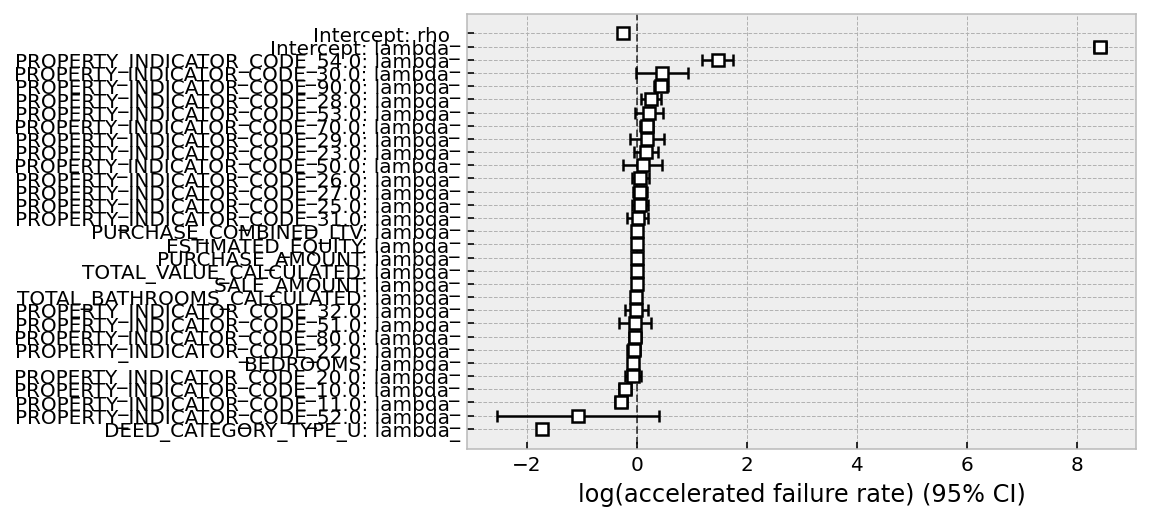

In [45]:
wft = WeibullAFTFitter().fit(X, 'date_difference', 'censor')
wft.plot()

In [ ]:
from lifelines import LogLogisticAFTFitter
from lifelines import LogNormalAFTFitter

llf = LogLogisticAFTFitter().fit(X, 'date_difference', 'censor')
lnf = LogNormalAFTFitter().fit(X, 'date_difference', 'censor')

In [ ]:
llf.print_summary(3)

In [ ]:
lnf.print_summary(3)

In [ ]:
print(cph.AIC_partial_) # lower is better


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/lifelines/calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))


ICI =  0.0015648178473364096
E50 =  0.0014559706061368916


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 25 mortality'}, xlabel='Predicted probability of \nt ≤ 25 mortality', ylabel='Observed probability of \nt ≤ 25 mortality'>,
 0.0015648178473364096,
 0.0014559706061368916)

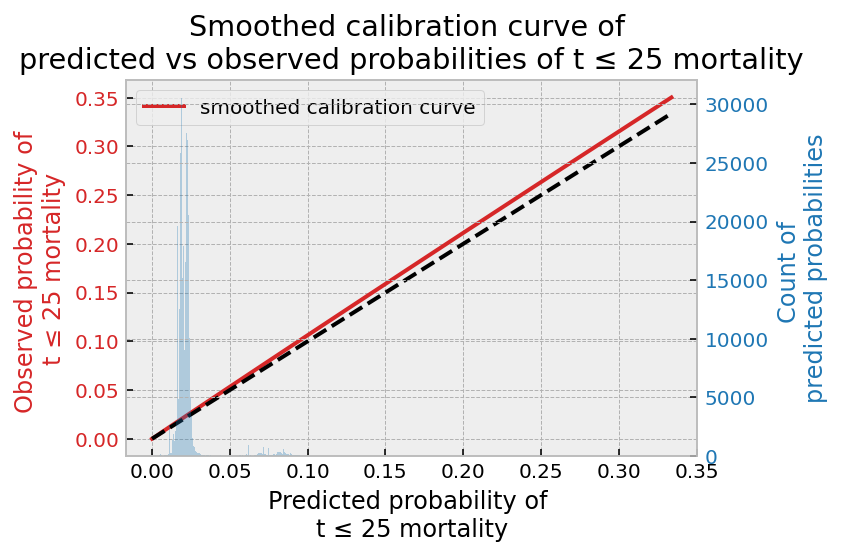

In [46]:
from lifelines.calibration import survival_probability_calibration
survival_probability_calibration(cph, X, t0=25)

In [ ]:
# filter down to just censored subjects to predict remaining survival
censored_subjects = X.loc[~X['censor'].astype(bool)]
censored_subjects_last_obs = censored_subjects['date_difference']

# predict new survival function
wft.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs)

# predict median remaining life
wft.predict_median(censored_subjects, conditional_after=censored_subjects_last_obs)